## 1. Setup and Data Prepration

In [1]:
# %pip install -q diffusers

In [2]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import torchvision.transforms as transforms

from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt

from tqdm.auto import tqdm
import os
import pandas as pd


device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [3]:
class DiatomDataset(Dataset):
    def __init__(self, split_csv, label_csv, root_dir, transform=None):
        """
        Args:
            split_csv (str): train.csv 或 test.csv 路径
            label_csv (str): label.csv 路径
            root_dir (str): 图片所在文件夹路径 (train/ 或 test/)
            transform (callable, optional): 图像转换
        """
        # 加载文件名列表
        self.file_list = pd.read_csv(split_csv, header=None, names=['filename'])
        
        # 加载标签映射
        label_df = pd.read_csv(label_csv, sep=",", header=None, names=["filename", "label"])
        self.label_map = dict(zip(label_df.filename, label_df.label))
        
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        # 获取文件名和标签
        img_name = self.file_list.iloc[idx, 0]
        img_path = os.path.join(self.root_dir, img_name)
        # 加载图像
        image = Image.open(img_path).convert("L")  # 如果彩色图用 "RGB"\
        
        # 查找标签
        if img_name not in self.label_map:
            raise ValueError(f"找不到标签: {img_name} 在 labels.csv")
        label = int(self.label_map[img_name])
        
        # 预处理
        if self.transform:
            image = self.transform(image)
        elif self.transform1:
            image = self.transform1(image)
        elif self.transform2:
            image = self.transform2(image)
        return image, label


In [4]:
# 图像处理pipeline
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),  # 彩色图
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# padding
'''
transform1 = transforms.Compose([
    transforms.Resize(128),
    transforms.Pad(padding=(0, (128 - image.size[1]) // 2)),  # 高度补齐
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
'''

# 裁剪缩放
transform2 = transforms.Compose([
    transforms.Lambda(lambda img: transforms.CenterCrop(min(img.size))(img)),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


# 路径变量
train_csv = "Dfinetune/train.csv"
test_csv  = "Dfinetune/test.csv"
label_csv = "Dfinetune/labels.csv"
train_root = "Dfinetune/train"
test_root  = "Dfinetune/test"

# 数据集和加载器
train_set = DiatomDataset(train_csv, label_csv, train_root, transform=transform2)
test_set  = DiatomDataset(test_csv,  label_csv, test_root,  transform=transform2)

train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
test_loader  = DataLoader(test_set,  batch_size=8, shuffle=False)


Batch shape: torch.Size([8, 1, 128, 128])
Labels: tensor([30, 34, 30, 14, 20, 16,  6,  3])


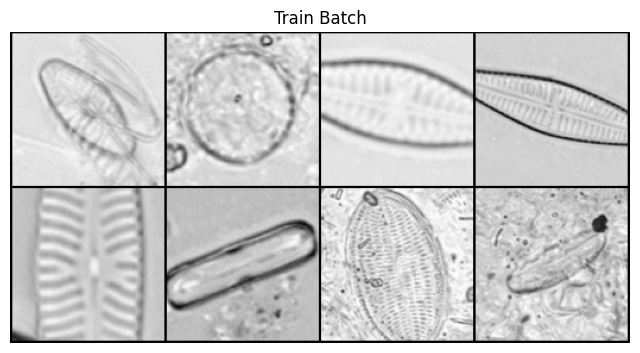

In [5]:
# 获取一个 batch, 验证加载
x, y = next(iter(train_loader))
print("Batch shape:", x.shape)
print("Labels:", y)

# 可视化
grid_img = torchvision.utils.make_grid(x, nrow=4, normalize=True)
plt.figure(figsize=(8, 8))
plt.imshow(grid_img.permute(1, 2, 0))
plt.title("Train Batch")
plt.axis('off')
plt.show()

In [6]:
img_path = "Dfinetune/test/HF_Sava_000468a_20220614_60x.x_9438.y_38379.png"

# 打开图片
img = Image.open(img_path)
print("图片分辨率:", img.size)  # (宽, 高)
print("图片模式:", img.mode)   # RGB or L(灰度)

图片分辨率: (186, 126)
图片模式: L


## 2. Creating a Class-Conditioned UNet

- Create a standard `UNet2DModel` with some additional input channels  
- Map the class label to a learned vector of shape `(class_emb_size)`via an embedding layer
- Concatenate this information as extra channels for the internal UNet input with `net_input = torch.cat((x, class_cond), 1)`
- Feed this `net_input` (which has (`class_emb_size+1`) channels in total) into the UNet to get the final prediction

In this example I've set the class_emb_size to 4, but this is completely arbitrary and you could explore having it size 1 (to see if it still works), size 10 (to match the number of classes), or replacing the learned nn.Embedding with a simple one-hot encoding of the class label directly.


In [7]:
class ClassConditionedUnet(nn.Module):
  def __init__(self, num_classes=36, class_emb_size=8):
    super().__init__()

    # The embedding layer will map the class label to a vector of size class_emb_size
    self.class_emb = nn.Embedding(num_classes, class_emb_size)

    # Self.model is an unconditional UNet with extra input channels to accept the conditioning information (the class embedding)
    self.model = UNet2DModel(
        sample_size=128,           # the target image resolution
        in_channels=1 + class_emb_size, # Additional input channels for class cond. if rgb then 3 +
        out_channels=1,           # the number of output channels
        layers_per_block=2,       # how many ResNet layers to use per UNet block
        block_out_channels=(32, 64, 64),
        down_block_types=(
            "DownBlock2D",        # a regular ResNet downsampling block
            "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
            "AttnDownBlock2D",
        ),
        up_block_types=(
            "AttnUpBlock2D",
            "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
            "UpBlock2D",          # a regular ResNet upsampling block
          ),
    )

  # Our forward method now takes the class labels as an additional argument
  def forward(self, x, t, class_labels):
    # Shape of x:
    bs, ch, w, h = x.shape

    # class conditioning in right shape to add as additional input channels
    class_cond = self.class_emb(class_labels) # Map to embedding dimension
    class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h)
    # x is shape (bs, 1, 28, 28) and class_cond is now (bs, 4, 28, 28)

    # concat image and class along dim 1
    net_input = torch.cat((x, class_cond), 1) # (bs, 5, 28, 28)

    # Feed this to the UNet alongside the timestep and return the prediction
    return self.model(net_input, t).sample # (bs, 1, 28, 28)

If any of the shapes or transforms are confusing, add in print statements to show the relevant shapes and check that they match your expectations. I've also annotated the shapes of some intermediate variables in the hopes of making things clearer.

## Training and Sampling

Where previously we'd do something like `prediction = unet(x, t)` we'll now add the correct labels as a third argument (`prediction = unet(x, t, y)`) during training, and at inference we can pass whatever labels we want and if all goes well the model should generate images that match. `y` in this case is the labels of the MNIST digits, with values from 0 to 9.

The training loop is very similar to the [example from Unit 1](https://github.com/huggingface/diffusion-models-class/blob/unit2/unit1/02_diffusion_models_from_scratch.ipynb). We're now predicting the noise (rather than the denoised image as in Unit 1) to match the objective expected by the default DDPMScheduler which we're using to add noise during training and to generate samples at inference time. Training takes a while - speeding this up could be a fun mini-project, but most of you can probably just skim the code (and indeed this whole notebook) without running it since we're just illustrating an idea.

In [8]:
from torch.cuda.amp import GradScaler, autocast

# Create a scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

/tmp/ipykernel_2985759/160743986.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # For AMP


  0%|          | 0/225 [00:00<?, ?it/s]

/tmp/ipykernel_2985759/160743986.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # AMP


Epoch 1/10 | Avg Loss: 0.160537 | GPU Mem: 61.0 MB
Saved new best model at epoch 1 with loss 0.160537


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 2/10 | Avg Loss: 0.073002 | GPU Mem: 62.0 MB
Saved new best model at epoch 2 with loss 0.073002


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 3/10 | Avg Loss: 0.059879 | GPU Mem: 61.0 MB
Saved new best model at epoch 3 with loss 0.059879


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 4/10 | Avg Loss: 0.054280 | GPU Mem: 62.0 MB
Saved new best model at epoch 4 with loss 0.054280


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 5/10 | Avg Loss: 0.052514 | GPU Mem: 61.0 MB
Saved new best model at epoch 5 with loss 0.052514


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 6/10 | Avg Loss: 0.048492 | GPU Mem: 62.0 MB
Saved new best model at epoch 6 with loss 0.048492


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 7/10 | Avg Loss: 0.047657 | GPU Mem: 61.0 MB
Saved new best model at epoch 7 with loss 0.047657


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 8/10 | Avg Loss: 0.048756 | GPU Mem: 62.0 MB


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 9/10 | Avg Loss: 0.045189 | GPU Mem: 61.0 MB
Saved new best model at epoch 9 with loss 0.045189


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 10/10 | Avg Loss: 0.043604 | GPU Mem: 62.0 MB
Saved new best model at epoch 10 with loss 0.043604


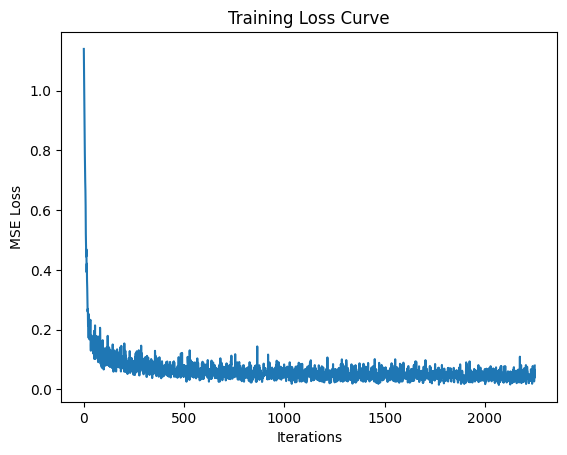

In [11]:
# Redefine dataloader with bigger batch size
train_dataloader = DataLoader(train_set, batch_size=32, shuffle=True)

# Network, loss, optimizer
net = ClassConditionedUnet().to(device)
loss_fn = nn.MSELoss()
# The optimizer
# opt = torch.optim.Adam(net.parameters(), lr=1e-3)
opt = torch.optim.AdamW(net.parameters(), lr=1e-4)  # AdamW 
scaler = GradScaler()  # For AMP

losses = []
n_epochs = 10
best_loss = float('inf')

for epoch in range(n_epochs):
    # net.train()
    for x, y in tqdm(train_dataloader):
        x = x.to(device) * 2 - 1
        y = y.to(device)
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (x.shape[0],)).long().to(device)
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

        # Get the model prediction
        # pred = net(noisy_x, timesteps, y) # Note that we pass in the labels y

        # Calculate the loss
        loss = loss_fn(pred, noise) # How close is the output to the noise

        # Backprop and update the params:
        opt.zero_grad()
        with autocast():  # AMP
            pred = net(noisy_x, timesteps, y)
            loss = loss_fn(pred, noise)
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()

        '''
        opt.zero_grad()
        loss.backward()
        opt.step()
        '''

        losses.append(loss.item())

    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f"Epoch {epoch+1}/{n_epochs} | Avg Loss: {avg_loss:.6f} | GPU Mem: {torch.cuda.memory_allocated()//1e6} MB")
    
    torch.save(net.state_dict(), f"checkpoints/checkpoint_epoch_{epoch+1}.pth")
    # 如果当前 loss 更好，就保存
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(net.state_dict(), "checkpoints/best_model.pth")
        print(f"Saved new best model at epoch {epoch+1} with loss {avg_loss:.6f}")
    
    
plt.plot(losses)
plt.title("Training Loss Curve")
plt.xlabel("Iterations")
plt.ylabel("MSE Loss")
plt.show()


### Once training finishes, we can sample some images feeding in different labels as our conditioning:

0it [00:00, ?it/s]

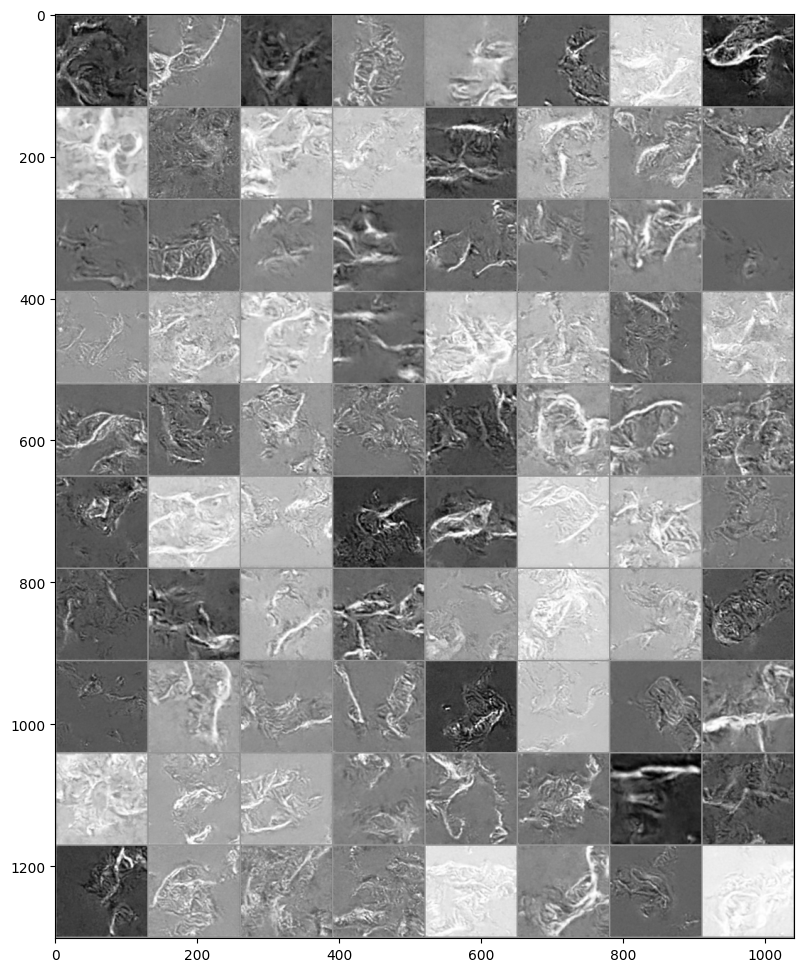

In [13]:
# Prepare random x to start from, plus desired labels y
num_classes = 36
samples_per_class = 8  # 每类生成几张
x = torch.randn(num_classes * samples_per_class, 1, 128, 128).to(device)
y = torch.tensor([[i] * samples_per_class for i in range(num_classes)]).flatten().to(device)

# Reverse diffusion (sampling loop)
for t in tqdm(noise_scheduler.timesteps):
    with torch.no_grad():
        residual = net(x, t, y)  # 条件在 class label
    x = noise_scheduler.step(residual, t, x).prev_sample

# Postprocess to [0, 1]
samples = (x.detach().cpu().clip(-1, 1) + 1) / 2

# Show grid of generated images
grid = torchvision.utils.make_grid(samples, nrow=samples_per_class)
plt.figure(figsize=(15, 15))
plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap="gray")
plt.axis("off")
plt.title("Generated Samples (Conditioned on Class Labels)")
plt.show()


In [16]:
# 替换为 DDIMScheduler 或 DPMSolverMultistepScheduler
from diffusers import DDIMScheduler
noise_scheduler = DDIMScheduler.from_config(noise_scheduler.config)
noise_scheduler.set_timesteps(50)

  0%|          | 0/50 [00:00<?, ?it/s]

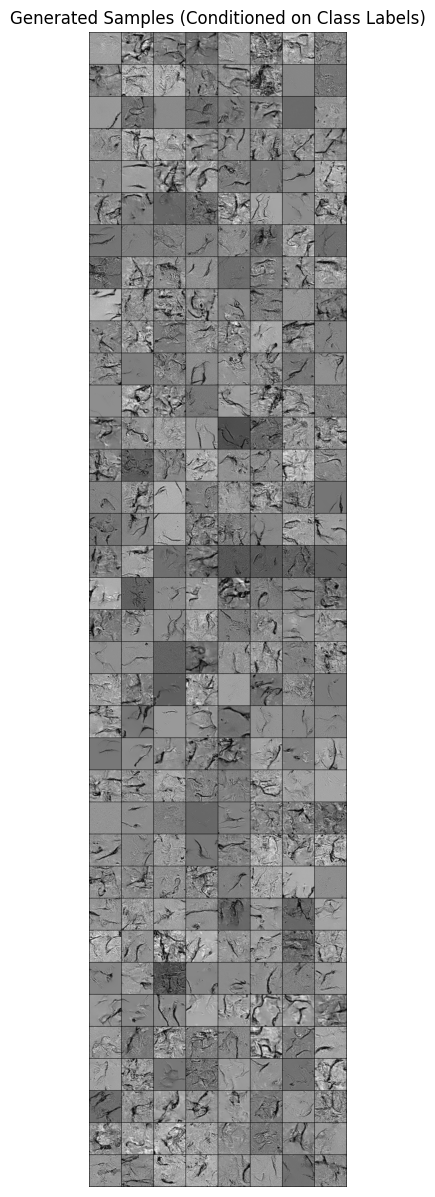

In [17]:
# Prepare random x to start from, plus desired labels y
num_classes = 36
samples_per_class = 8  # 每类生成几张
x = torch.randn(num_classes * samples_per_class, 1, 128, 128).to(device)
y = torch.tensor([[i] * samples_per_class for i in range(num_classes)]).flatten().to(device)

# Reverse diffusion (sampling loop)
for t in tqdm(noise_scheduler.timesteps):
    with torch.no_grad():
        residual = net(x, t, y)  # 条件在 class label
    x = noise_scheduler.step(residual, t, x).prev_sample

# Postprocess to [0, 1]
samples = (x.detach().cpu().clip(-1, 1) + 1) / 2

# Show grid of generated images
grid = torchvision.utils.make_grid(samples, nrow=samples_per_class)
plt.figure(figsize=(15, 15))
plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap="gray")
plt.axis("off")
plt.title("Generated Samples (Conditioned on Class Labels)")
plt.show()


# 4. Evaluation

In [ ]:
import torch
from torchvision import models, transforms
from torchvision.utils import make_grid
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import structural_similarity as ssim
from pytorch_fid import fid_score
import lpips

# 预处理 & 加载分类器
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])
resnet50 = models.resnet50(pretrained=True).eval()

# LPIPS 模型
lpips_fn = lpips.LPIPS(net='alex').eval()

def get_predicted_class(img_pil):
    """用 ResNet50 预测图片类别"""
    input_tensor = preprocess(img_pil).unsqueeze(0)
    with torch.no_grad():
        output = resnet50(input_tensor)
    return output.argmax(dim=1).item()

def compute_metrics(original_images, generated_images, target_classes, class_labels):
    """
    original_images, generated_images: list of PIL.Image
    target_classes: list of int (target class index)
    class_labels: dict {class_index: class_name}
    """
    correct = 0
    ssim_scores, psnr_scores, lpips_scores = [], [], []
    
    for orig, gen, target in zip(original_images, generated_images, target_classes):
        # 分类器评估
        pred_class = get_predicted_class(gen)
        if pred_class == target:
            correct += 1
        
        # SSIM
        ssim_val = ssim(np.array(orig.convert('L')), np.array(gen.convert('L')))
        ssim_scores.append(ssim_val)
        
        # PSNR
        mse = np.mean((np.array(orig) - np.array(gen)) ** 2)
        psnr_val = 20 * np.log10(255.0 / np.sqrt(mse)) if mse > 0 else 100
        psnr_scores.append(psnr_val)
        
        # LPIPS
        lpips_val = lpips_fn(preprocess(orig).unsqueeze(0), preprocess(gen).unsqueeze(0))
        lpips_scores.append(lpips_val.item())
        
        # 可视化
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        axes[0].imshow(orig)
        axes[0].set_title(f"Original: {class_labels[target]}")
        axes[1].imshow(gen)
        axes[1].set_title(f"Generated (Pred: {class_labels[pred_class]})")
        diff = np.abs(np.array(orig).astype(float) - np.array(gen).astype(float))
        axes[2].imshow(diff.astype(np.uint8))
        axes[2].set_title("Difference Map")
        for ax in axes: ax.axis('off')
        plt.show()
    
    accuracy = correct / len(generated_images)
    print(f"\n Class-conditioned Accuracy: {accuracy:.2%}")
    print(f"Avg SSIM: {np.mean(ssim_scores):.4f}")
    print(f"Avg PSNR: {np.mean(psnr_scores):.2f} dB")
    print(f"Avg LPIPS: {np.mean(lpips_scores):.4f}")
    
    # 可选: FID (需要把图片存到目录)
    # fid_value = fid_score.calculate_fid_given_paths([gen_dir, orig_dir], batch_size=50, device='cuda', dims=2048)
    # print(f"FID: {fid_value:.2f}")

    return {
        "accuracy": accuracy,
        "ssim": np.mean(ssim_scores),
        "psnr": np.mean(psnr_scores),
        "lpips": np.mean(lpips_scores)
    }


In [ ]:
# 加载 ImageNet 标签
import json
with open("imagenet_class_index.json") as f:
    class_labels = {int(k): v[1] for k, v in json.load(f).items()}

# 调用综合评估
results = compute_metrics(original_images, generated_images, target_classes, class_labels)